# PSTAT235 Team Assignment -Group 28

In [1]:
# load AZ data
bucket_dir="gs://pstat135-voter-file/VM2Uniform/"
df = spark.read.parquet(bucket_dir + 'VM2Uniform--AZ--2021-05-20')

In [2]:
# Read MA data
dfma = spark.read.parquet(bucket_dir + 'VM2Uniform--MA--2021-01-19')

In [3]:
# load ND data
dfnd = spark.read.parquet(bucket_dir + 'VM2Uniform--ND--2021-03-18')

# Arizona

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import split, explode
from pyspark.sql.types import IntegerType

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("Voter Data Analysis").getOrCreate()

In [6]:
# the total records output
df.count()

4266400

In [7]:
df.printSchema()

root
 |-- SEQUENCE: string (nullable = true)
 |-- LALVOTERID: string (nullable = true)
 |-- Voters_Active: string (nullable = true)
 |-- Voters_StateVoterID: string (nullable = true)
 |-- Voters_CountyVoterID: string (nullable = true)
 |-- VoterTelephones_LandlineAreaCode: string (nullable = true)
 |-- VoterTelephones_Landline7Digit: string (nullable = true)
 |-- VoterTelephones_LandlineFormatted: string (nullable = true)
 |-- VoterTelephones_LandlineUnformatted: string (nullable = true)
 |-- VoterTelephones_LandlineConfidenceCode: string (nullable = true)
 |-- VoterTelephones_CellPhoneOnly: string (nullable = true)
 |-- VoterTelephones_CellPhoneFormatted: string (nullable = true)
 |-- VoterTelephones_CellPhoneUnformatted: string (nullable = true)
 |-- VoterTelephones_CellConfidenceCode: string (nullable = true)
 |-- Voters_FirstName: string (nullable = true)
 |-- Voters_MiddleName: string (nullable = true)
 |-- Voters_LastName: string (nullable = true)
 |-- Voters_NameSuffix: string (

In [8]:
# select some variables we are interested in from the data
df_need = df.select("Voters_Age",
                    "Voters_Gender",
                    "CommercialData_EstimatedHHIncomeAmount", 
                    "CommercialData_EstHomeValue",
                    "CommercialData_Education",
                    "ElectionReturns_G08CountyTurnoutAllRegisteredVoters")
df_need.show(10)

+----------+-------------+--------------------------------------+---------------------------+------------------------+---------------------------------------------------+
|Voters_Age|Voters_Gender|CommercialData_EstimatedHHIncomeAmount|CommercialData_EstHomeValue|CommercialData_Education|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|
+----------+-------------+--------------------------------------+---------------------------+------------------------+---------------------------------------------------+
|        96|            F|                                  null|                       null|                    null|                                                55%|
|        68|            M|                                  null|                       null|                    null|                                                55%|
|        66|            F|                                  null|                       null|                    null|                           

## Turnout rate

In [9]:
# drop Null values and show statistical description 
turnout_df = df_need.select("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
turnout_df = turnout_df.withColumn(
    "ElectionReturns_G08CountyTurnoutAllRegisteredVoters", 
    regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType())
)

turnout_df.describe(["ElectionReturns_G08CountyTurnoutAllRegisteredVoters"]).show()

+-------+---------------------------------------------------+
|summary|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|
+-------+---------------------------------------------------+
|  count|                                            4266400|
|   mean|                                  67.87103858053628|
| stddev|                                  4.810402158743543|
|    min|                                                 53|
|    max|                                                 76|
+-------+---------------------------------------------------+



Text(0, 0.5, 'Frequency')

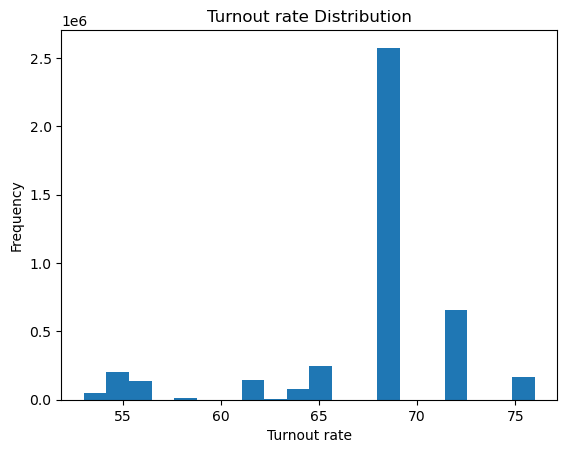

In [10]:
# Plot its distribution
data = turnout_df.sort("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").toPandas()
plt.hist(data, bins=20)
plt.title('Turnout rate Distribution')
plt.xlabel('Turnout rate')
plt.ylabel('Frequency')

## Age

In [11]:
# drop Null values and show statistical description 
age_df = df_need.select("Voters_Age").na.drop()
age_df.describe(["Voters_Age"]).show()

+-------+------------------+
|summary|        Voters_Age|
+-------+------------------+
|  count|           4263282|
|   mean|50.750146952512175|
| stddev|  19.2521074283818|
|    min|                18|
|    max|                99|
+-------+------------------+



Text(0, 0.5, 'Frequency')

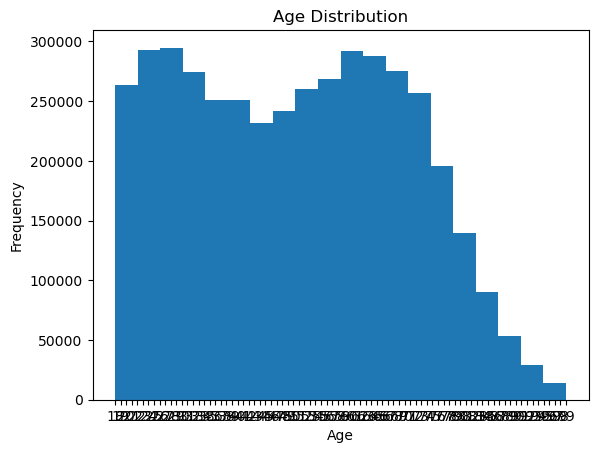

In [12]:
# Plot its distribution
data = age_df.sort("Voters_Age").toPandas()
plt.hist(data, bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

## Gender

In [13]:
# drop Null values and show statistical description 
sex_df = df_need.select("Voters_Gender").na.drop()
sex_df.groupBy("Voters_Gender").count().show()

+-------------+-------+
|Voters_Gender|  count|
+-------------+-------+
|            F|2199156|
|            M|2044425|
+-------------+-------+



Text(0, 0.5, 'Frequency')

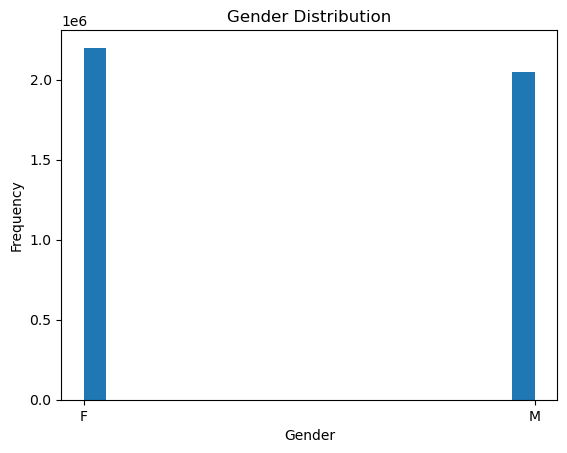

In [14]:
# Plot its distribution
data = sex_df.sort("Voters_Gender").toPandas()
plt.hist(data, bins=20)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Frequency')

## education level

In [15]:
# drop Null values and show statistical description 
edu_df = df_need.select("CommercialData_Education").na.drop()
edu_df.groupBy("CommercialData_Education").count().show()

+------------------------+------+
|CommercialData_Education| count|
+------------------------+------+
|    Grad Degree - Ext...|178758|
|    Grad Degree - Likely|164353|
|    Bach Degree - Ext...|363891|
|     HS Diploma - Likely|273882|
|    Less than HS Dipl...|   428|
|    Some College - Li...|518686|
|    Vocational Techni...|  3245|
|    Some College -Ext...|129280|
|    HS Diploma - Extr...|275538|
|    Less than HS Dipl...|125872|
|    Bach Degree - Likely|248133|
+------------------------+------+



## Household income

In [16]:
# drop Null values and show statistical description 
hhincome_df = df_need.select("CommercialData_EstimatedHHIncomeAmount").na.drop()
hhincome_df = hhincome_df.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast(IntegerType()))

hhincome_df.describe(["CommercialData_EstimatedHHIncomeAmount"]).show()

+-------+--------------------------------------+
|summary|CommercialData_EstimatedHHIncomeAmount|
+-------+--------------------------------------+
|  count|                               4094070|
|   mean|                     91015.27526275809|
| stddev|                     55405.45704429405|
|    min|                                     0|
|    max|                                250000|
+-------+--------------------------------------+



Text(0, 0.5, 'Frequency')

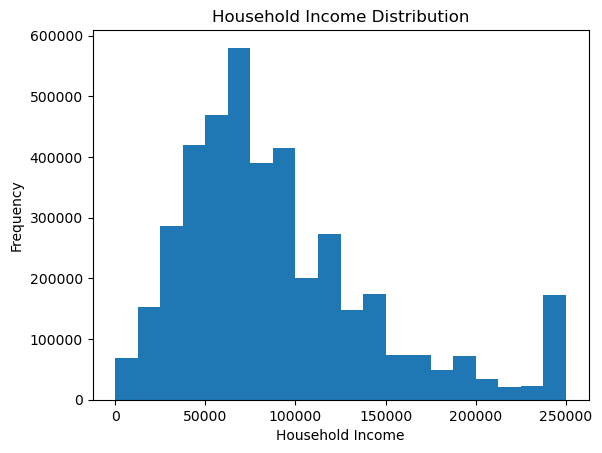

In [17]:
# Plot its distribution
data = hhincome_df.sort("CommercialData_EstimatedHHIncomeAmount").toPandas()
plt.hist(data, bins=20)
plt.title('Household Income Distribution')
plt.xlabel('Household Income')
plt.ylabel('Frequency')

## Relationship between education level and voter turnout

In [18]:
# voter turnout by education level
education_turnout_df = df_need.select("CommercialData_Education","ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
education_turnout_df = education_turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
education_turnout_count = education_turnout_df.groupBy("CommercialData_Education").agg(avg("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").alias("count")).sort("count")
education_turnout_count.show(10)

+------------------------+-----------------+
|CommercialData_Education|            count|
+------------------------+-----------------+
|    Less than HS Dipl...|66.79281333418075|
|    Less than HS Dipl...|67.18691588785046|
|    Vocational Techni...| 67.2135593220339|
|     HS Diploma - Likely|67.43301129683586|
|    HS Diploma - Extr...|67.68589450456925|
|    Some College -Ext...|67.93788675742574|
|    Some College - Li...| 67.9557130903861|
|    Bach Degree - Ext...|68.23535619182667|
|    Bach Degree - Likely|68.64970398939279|
|    Grad Degree - Likely|68.73700510486574|
+------------------------+-----------------+
only showing top 10 rows



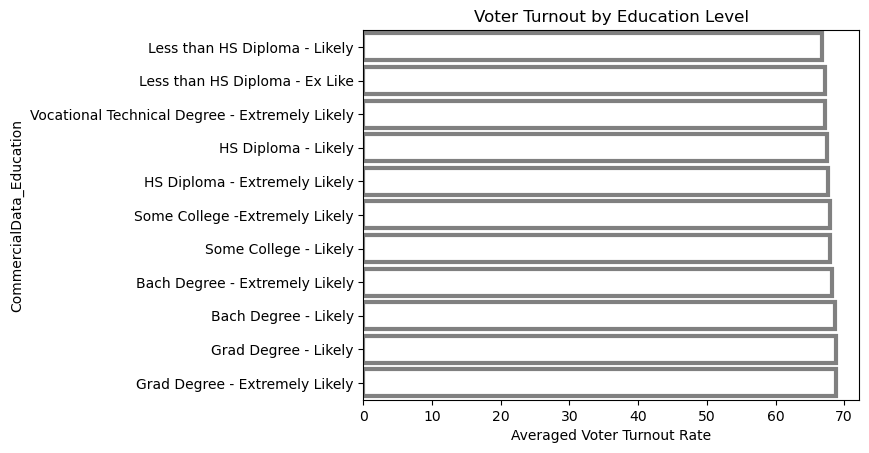

In [19]:
sns.barplot(data=education_turnout_count.toPandas(), x="count", y="CommercialData_Education",
            linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))
plt.title("Voter Turnout by Education Level")
plt.xlabel('Averaged Voter Turnout Rate')
plt.show()

## Relationship between HH income and voter turnout

In [20]:
# voter turnout by HH income
hhincome_turnout_df = df_need.select("CommercialData_EstimatedHHIncomeAmount","ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
hhincome_turnout_df = hhincome_turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
hhincome_turnout_df = hhincome_turnout_df.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast(IntegerType()))
hhincome_turnout_df = hhincome_turnout_df.sort("CommercialData_EstimatedHHIncomeAmount")



In [21]:
hhincome_turnout_df = df_need.select("CommercialData_EstimatedHHIncomeAmount","ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
hhincome_turnout_df = hhincome_turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
hhincome_turnout_df = hhincome_turnout_df.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast(IntegerType()))
hhincome_turnout_count = hhincome_turnout_df.groupBy("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").agg(avg("CommercialData_EstimatedHHIncomeAmount").alias("count")).sort("ElectionReturns_G08CountyTurnoutAllRegisteredVoters")

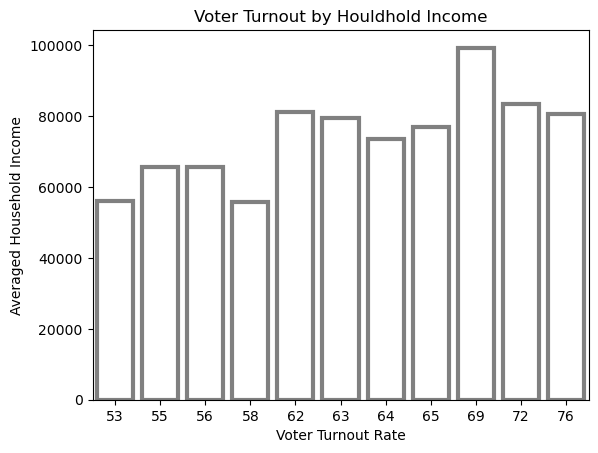

In [22]:
sns.barplot(data=hhincome_turnout_count.toPandas(), x="ElectionReturns_G08CountyTurnoutAllRegisteredVoters", y="count",
            linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))
plt.title("Voter Turnout by Houldhold Income")
plt.xlabel('Voter Turnout Rate')
plt.ylabel('Averaged Household Income')
plt.show()

## Relationship between age+gender with voter turnout

In [24]:
age_sex_turnout_df = df_need.select("Voters_Age","Voters_Gender","ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
age_sex_turnout_df = age_sex_turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
age_sex_turnout_count = age_sex_turnout_df.groupBy("Voters_Age","Voters_Gender").agg(avg("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").alias("count")).sort("count")



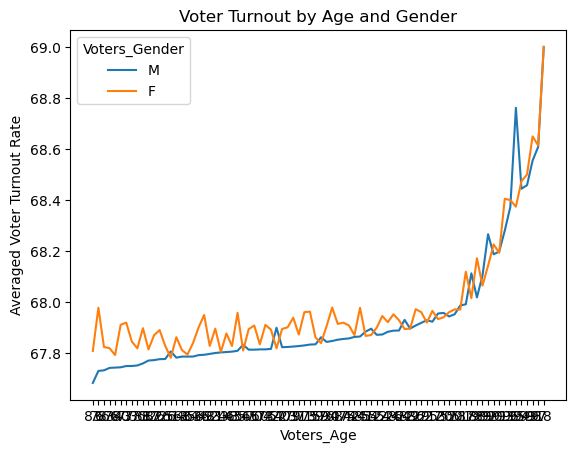

In [25]:
sns.lineplot(data=age_sex_turnout_count.toPandas(), x="Voters_Age", y="count", hue="Voters_Gender")
plt.title("Voter Turnout by Age and Gender")
plt.ylabel('Averaged Voter Turnout Rate')
plt.show()

## Model

In [26]:
# Import required libraries
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor

In [33]:
# select some variables we are interested in from the data
spark.conf.set("spark.sql.debug.maxToStringFields", 1000) 
df_need = df.select("Voters_Age",
                    "Voters_Gender",
                    "CommercialData_Education",
                    "EthnicGroups_EthnicGroup1Desc",
                    "CommercialData_EstimatedHHIncomeAmount", 
                    "CommercialData_EstHomeValue",
                    "ElectionReturns_G08CountyTurnoutAllRegisteredVoters")
# Drop missing values 
df_need = df_need.na.drop()

df_need.show(10)

+----------+-------------+------------------------+-----------------------------+--------------------------------------+---------------------------+---------------------------------------------------+
|Voters_Age|Voters_Gender|CommercialData_Education|EthnicGroups_EthnicGroup1Desc|CommercialData_EstimatedHHIncomeAmount|CommercialData_EstHomeValue|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|
+----------+-------------+------------------------+-----------------------------+--------------------------------------+---------------------------+---------------------------------------------------+
|        63|            F|     HS Diploma - Likely|                     European|                                 59000|                     112500|                                                 55|
|        58|            M|    HS Diploma - Extr...|                        Other|                                 79000|                      37500|                                                

In [34]:
# convert string columns to numeric 
df = df.withColumn("ElectionReturns_G18CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G18CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
df = df.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast(IntegerType()))
df = df.withColumn("CommercialData_EstHomeValue", expr("substring(CommercialData_EstHomeValue, 2, length(CommercialData_EstHomeValue))").cast(IntegerType()))
df = df.withColumn("Voters_Age", df_need["Voters_Age"].cast(IntegerType()))

In [35]:
# Create string indexer and one-hot encoder for categorical columns
ethnic_group_indexer = StringIndexer(inputCol="EthnicGroups_EthnicGroup1Desc", outputCol="ethnic_group_index")
gender_indexer = StringIndexer(inputCol="Voters_Gender", outputCol="gender_index")
education_indexer = StringIndexer(inputCol="CommercialData_Education", outputCol="education_index")


ethnic_group_encoder = OneHotEncoder(inputCol="ethnic_group_index", outputCol="ethnic_group_vec")
gender_encoder = OneHotEncoder(inputCol="gender_index", outputCol="gender_vec")
education_encoder = OneHotEncoder(inputCol="education_index", outputCol="education_vec")

In [36]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import count

# Define the age groups or bins
splits = [-float("inf"), 18, 25, 35, 45, 55, 65, float("inf")]

# Create the Bucketizer object and set the input and output columns
bucketizer = Bucketizer(splits=splits, inputCol="Voters_Age", outputCol="AgeGroup")

# Apply the Bucketizer transformation to the dataframe
df_bucketed = bucketizer.transform(df)

# Group by county and age group and count the number of records in each group
counties_df = df_bucketed.groupBy("County", "AgeGroup").agg(count("*").alias("Count"))

# Pivot the data to have age groups as columns
counties_df_pivoted = counties_df.groupBy("County").pivot("AgeGroup").sum("Count")

# Rename the columns to reflect the age groups
age_groups = ["0-18", "19-25", "26-35", "36-45", "46-55", "56-65", "66+"]
for i, age_group in enumerate(age_groups):
    counties_df_pivoted = counties_df_pivoted.withColumnRenamed(str(i), age_group)


In [68]:

counties_df = df_bucketed.select(
    "County", "AgeGroup", "CommercialData_EstimatedHHIncomeAmount", 
    "CommercialData_EstHomeValue",
    "ElectionReturns_G08CountyTurnoutAllRegisteredVoters"
).groupBy("County", "AgeGroup").agg(
    mean("CommercialData_EstimatedHHIncomeAmount").alias("CommercialData_EstimatedHHIncomeAmount"),
    mean("CommercialData_EstHomeValue").alias("CommercialData_EstHomeValue"),
    mean("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").alias("ElectionReturns_G08CountyTurnoutAllRegisteredVoters")
)

In [69]:
counties_df.show()

+----------+--------+--------------------------------------+---------------------------+---------------------------------------------------+
|    County|AgeGroup|CommercialData_EstimatedHHIncomeAmount|CommercialData_EstHomeValue|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|
+----------+--------+--------------------------------------+---------------------------+---------------------------------------------------+
|    LA PAZ|     4.0|                     7474.398104265403|             36998.53515625|                                               58.0|
|  COCONINO|    null|                     7846.133333333333|         50273.933333333334|                                               62.0|
|   YAVAPAI|     1.0|                    12482.389231305966|          54429.21380689168|                                               76.0|
|   COCHISE|    null|                     7626.242424242424|          45465.23529411765|                                               64.0|
|  MARICOPA| 

In [70]:
# Create vector assembler to combine all features
assembler = VectorAssembler(
    inputCols=[
        "AgeGroup", "CommercialData_EstimatedHHIncomeAmount", 
        "CommercialData_EstHomeValue"
    ],
    outputCol="features"
)

In [71]:
# Create random forest regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="ElectionReturns_G08CountyTurnoutAllRegisteredVoters")

# Create a pipeline for all transformations and the model
pipeline = Pipeline(stages=[assembler, rf])

# Split the data into training and testing sets
(train_data, test_data) = counties_df.randomSplit([0.7, 0.3], seed=100)

# Fit the pipeline to the training data
model = pipeline.fit(train_data)

# Make predictions on the testing data
predictions = model.transform(test_data)

23/03/17 20:10:00 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 125.0 (TID 288) (mycluster-m.us-central1-c.c.pstat235-sk.internal executor 1): org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$Lambda$4029/1518026192: (struct<AgeGroup:double,CommercialData_EstimatedHHIncomeAmount:double,CommercialData_EstHomeValue:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collec

Py4JJavaError: An error occurred while calling o1288.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 125.0 failed 4 times, most recent failure: Lost task 1.3 in stage 125.0 (TID 295) (mycluster-m.us-central1-c.c.pstat235-sk.internal executor 1): org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$$Lambda$4029/1518026192: (struct<AgeGroup:double,CommercialData_EstimatedHHIncomeAmount:double,CommercialData_EstHomeValue:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1207)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2298)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 25 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2304)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2252)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2491)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2433)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2422)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:902)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2204)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2299)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$1(RDD.scala:1209)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.aggregate(RDD.scala:1202)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:125)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:274)
	at org.apache.spark.ml.regression.RandomForestRegressor.$anonfun$train$1(RandomForestRegressor.scala:150)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:134)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:43)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(VectorAssembler$$Lambda$4029/1518026192: (struct<AgeGroup:double,CommercialData_EstimatedHHIncomeAmount:double,CommercialData_EstHomeValue:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1207)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2298)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 25 more


In [ ]:
# Evaluate the performance of the model on the test data
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

evaluator = RegressionEvaluator(
    labelCol="ElectionReturns_G18CountyTurnoutAllRegisteredVoters", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)

print(f"RMSE on the test data: {rmse}")